In [30]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from scipy.stats import norm, probplot

# params
levels = 50
bias = 0.5

In [31]:
# first, we build the QGB as a classical network (not neural net)
def build_galton_graph(levels, bias):
    G = nx.DiGraph()
    node_id = lambda level, pos: f"{level}-{pos}"

    for level in range(levels):
        for pos in range(level + 1):
            curr = node_id(level, pos)
            left = node_id(level + 1, pos)
            right = node_id(level + 1, pos + 1)
            G.add_edge(curr, left, weight=1 - bias)
            G.add_edge(curr, right, weight=bias)

    return G
#we'll do a direct graph

In [32]:
#  Simulate Random Walk
def simulate_distribution(G, levels):
    start = "0-0"
    dist = {node: 0.0 for node in G.nodes()}
    dist[start] = 1.0

    for level in range(levels):
        next_dist = {node: 0.0 for node in G.nodes()}
        for node in dist:
            for succ in G.successors(node):
                next_dist[succ] += dist[node] * G[node][succ]['weight']
        dist = next_dist

    final_nodes = [n for n in dist if n.startswith(f"{levels}-")]
    probs = np.array([dist[n] for n in final_nodes])
    return probs / np.sum(probs), final_nodes


In [33]:
# QAOA Optimization processing
def qaoa_postprocess(probs, gamma=1.0, beta=0.5):
    angles = np.linspace(-np.pi, np.pi, len(probs))
    phased = probs * np.cos(gamma * angles) ** 2
    mixed = np.fft.ifft(np.fft.fft(phased) * np.exp(-1j * beta)).real
    return np.clip(mixed, 0, None) / np.sum(np.clip(mixed, 0, None))

In [34]:

def total_variation_distance(p, q):
    return 0.5 * np.sum(np.abs(p - q))

#there are a lotta of statistical distances so we can test em out
# maybe like euclidean or manhattan

In [35]:
# Run it
G = build_galton_graph(levels, bias)
probs, final_nodes = simulate_distribution(G, levels)
probs_qaoa = qaoa_postprocess(probs)

In [37]:
# normal distirbution for comparison

x_vals = np.linspace(-3, 3, len(probs))
normal_pdf = norm.pdf(x_vals)
normal_pdf /= np.sum(normal_pdf)

# find distances
tvd_original = total_variation_distance(probs, normal_pdf)
tvd_qaoa = total_variation_distance(probs_qaoa, normal_pdf)

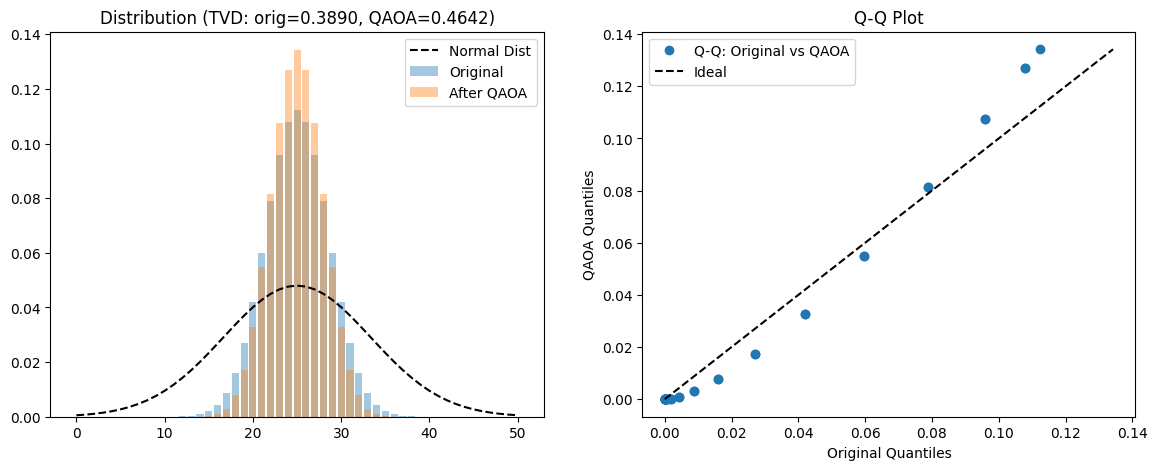

In [38]:
#so first plot probability distributions

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].bar(np.arange(len(probs)), probs, alpha=0.4, label="Original")
axs[0].bar(np.arange(len(probs_qaoa)), probs_qaoa, alpha=0.4, label="After QAOA")
axs[0].plot(np.arange(len(normal_pdf)), normal_pdf, 'k--', label="Normal Dist")
axs[0].set_title(f"Distribution (TVD: orig={tvd_original:.4f}, QAOA={tvd_qaoa:.4f})")
axs[0].legend()

#Then we do the QQ plot

axs[1].plot(np.sort(probs), np.sort(probs_qaoa), 'o', label="Q-Q: Original vs QAOA")
axs[1].plot([0, max(probs.max(), probs_qaoa.max())], [0, max(probs.max(), probs_qaoa.max())], 'k--', label="Ideal")
axs[1].set_xlabel("Original Quantiles")
axs[1].set_ylabel("QAOA Quantiles")
axs[1].set_title("Q-Q Plot")
axs[1].legend()
plt.show()